# Project 3 Part 2 Core
**Student:** Matthew Malueg

### Imports, Functions

In [1]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import holidays
import datetime as dt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

### Loading and Exploring Data

In [6]:
folder = 'Data/Chicago/'
crime_files = sorted(glob.glob(folder+'*.csv'))
df = pd.concat([pd.read_csv(f) for f in crime_files])

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [8]:
mask = (df['Primary Type'] == 'ASSAULT') | (df['Primary Type'] == 'NARCOTICS')

In [9]:
mask_df = df[mask]
mask_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247258 entries, 14 to 238856
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1247258 non-null  int64  
 1   Date                  1247258 non-null  object 
 2   Primary Type          1247258 non-null  object 
 3   Description           1247258 non-null  object 
 4   Location Description  1247200 non-null  object 
 5   Arrest                1247258 non-null  bool   
 6   Domestic              1247258 non-null  bool   
 7   Beat                  1247258 non-null  int64  
 8   District              1247253 non-null  float64
 9   Ward                  1140129 non-null  float64
 10  Latitude              1232447 non-null  float64
 11  Longitude             1232447 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 107.1+ MB


In [10]:
ts = mask_df[['Date', 'Primary Type']]
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247258 entries, 14 to 238856
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Date          1247258 non-null  object
 1   Primary Type  1247258 non-null  object
dtypes: object(2)
memory usage: 28.5+ MB


In [11]:
ts['Date'] = pd.to_datetime(ts['Date'])

C:\Users\Malue\AppData\Local\Temp\ipykernel_8904\3970516155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['Date'] = pd.to_datetime(ts['Date'])


In [12]:
ts = ts.set_index('Date')
ts.info()
ts.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1247258 entries, 2001-01-01 01:00:00 to 2022-12-31 12:52:00
Data columns (total 1 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Primary Type  1247258 non-null  object
dtypes: object(1)
memory usage: 19.0+ MB


,Primary Type
Date,
2001-01-01 01:00:00,ASSAULT
2001-01-01 13:00:00,NARCOTICS
2001-01-01 13:00:00,ASSAULT
2001-01-01 13:00:00,ASSAULT
2001-01-01 01:02:29,ASSAULT


## Analyze Two Crime Types - Narcotics and Assault

### Narcotics

#### Examine and prepare data for analysis

In [62]:
# Select only narcotics data for analysis
narc_ts = ts[ts['Primary Type'] == 'NARCOTICS']
narc_ts

,Primary Type
Date,
2001-01-01 13:00:00,NARCOTICS
2001-01-01 13:10:00,NARCOTICS
2001-01-01 13:10:00,NARCOTICS
2001-01-01 01:12:00,NARCOTICS
2001-01-01 13:20:00,NARCOTICS
...,...
2022-12-31 15:37:00,NARCOTICS
2022-12-31 16:20:00,NARCOTICS
2022-12-31 17:03:00,NARCOTICS


**Resample as monthly freq with .size()**

In [63]:
# Resample the dataframe as monthly frequency
narc_ts = narc_ts.resample('M').size()
narc_ts

Date
2001-01-31    4714
2001-02-28    4369
2001-03-31    4862
2001-04-30    4044
2001-05-31    4038
              ... 
2022-08-31     420
2022-09-30     379
2022-10-31     358
2022-11-30     339
2022-12-31     325
Freq: M, Length: 264, dtype: int64

**Check for null values**

In [64]:
# Check nulls
narc_ts.isna().sum()

0

**Seasonality**

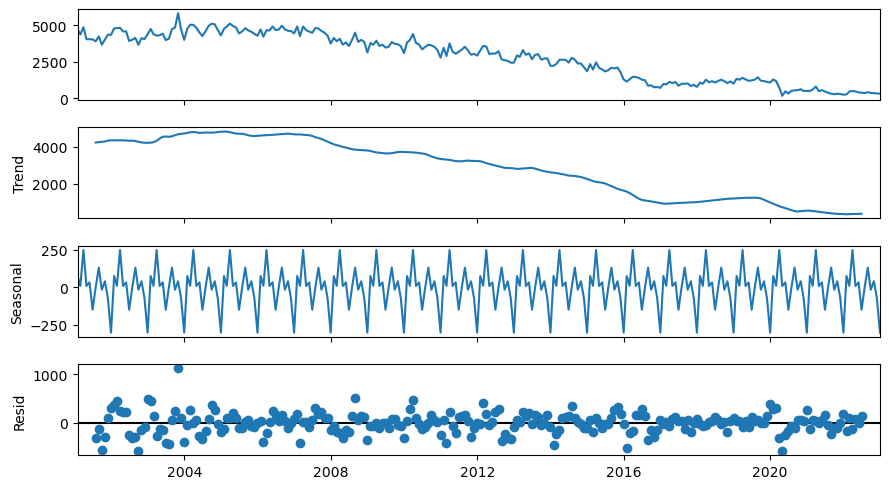

In [65]:
# Use seasonal decompose to check for seasonality
decomp = tsa.seasonal_decompose(narc_ts)
fig = decomp.plot()
fig.set_size_inches(9,5)
fig.tight_layout()

- Time series appears to have 12-month seasonality (m = 12)

In [66]:
# Assess absolute and relative size of seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {round(seasonal_delta,2)} which is ~{seasonal_delta/(narc_ts.max()-narc_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 550.66 which is ~9.76% of the variation in time series.


**Stationarity**

In [67]:
# Check ndiffs and nsdiffs
d = ndiffs(narc_ts)
print(f'd = {d}')
D = nsdiffs(narc_ts, m=12)
print(f'D = {D}')

d = 1
D = 0


In [68]:
# Check stationarity
get_adfuller_results(narc_ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.265472,12,251,0.975704,0.05,False


In [69]:
# Apply differencing, check again
narc_diff = narc_ts.diff().dropna()
get_adfuller_results(narc_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.393766,11,251,0.000003,0.05,True


**ACF/PACF Plots**

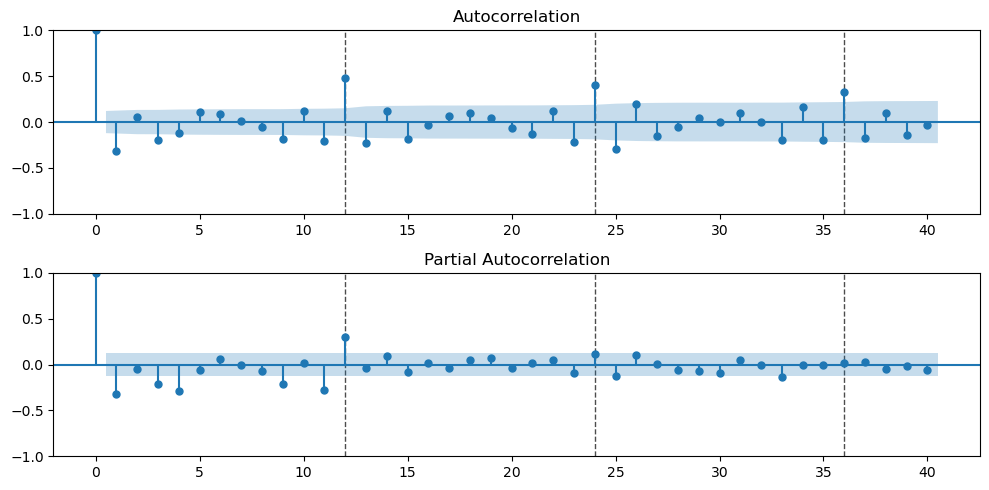

In [70]:
# Obtain autocorrelation plots
plot_acf_pacf(narc_diff, annotate_seas=True, m=12);

- The nonseasonal plots show both models continuing to have lags outside the confidence interal regularly but with decreasing frequency and magnitude.
- There does not at first examination appear to be a specific lag with a sudden drop, so ARMA 1, 1 will be chosen.
- For seasonal ACF shows a continuing but slow decrease, while the decrease for PACF seems more sudden after the first lag. Try AR(1) here.

**TTS**

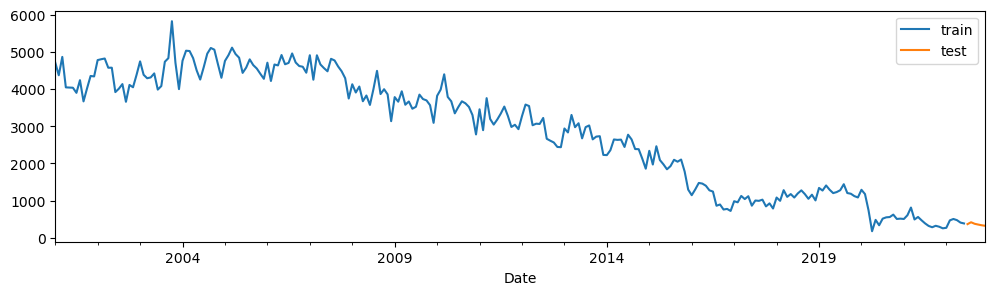

In [71]:
train, test = train_test_split(narc_ts, test_size=6)

## Visualize train-test-split
ax = train.plot(label="train")
test.plot(label="test")
ax.legend();

#### Initial SARIMA Model

In [24]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components (if seasonal model)
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [25]:
# Examine model summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1778.793
Date:                           Fri, 08 Dec 2023   AIC                           3565.587
Time:                                   17:33:09   BIC                           3579.783
Sample:                               01-31-2001   HQIC                          3571.296
                                    - 06-30-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5096      0.082      6.245      0.000       0.350       0.669
ma.L1         -0.8290      0.057    -14.431      0.000      -0.942      -0.716
ar.S.L12       0.4893      0.049      9.889      0.000       0.392       0.586
sigma2      5.968e+04   4037.217     14.783      0.000    5.18e+04    6.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                33.71
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

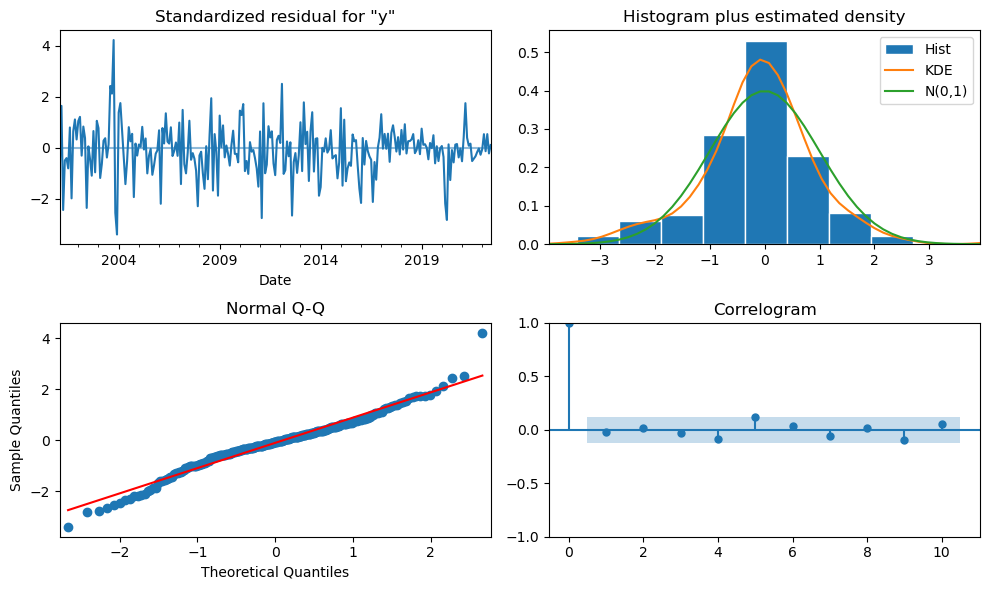

In [26]:
# Check diagnosti plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- Only Lag 4 in the Correlogram stands out as being possibly worth investigation, otherwise the model looks to be performing well so far.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

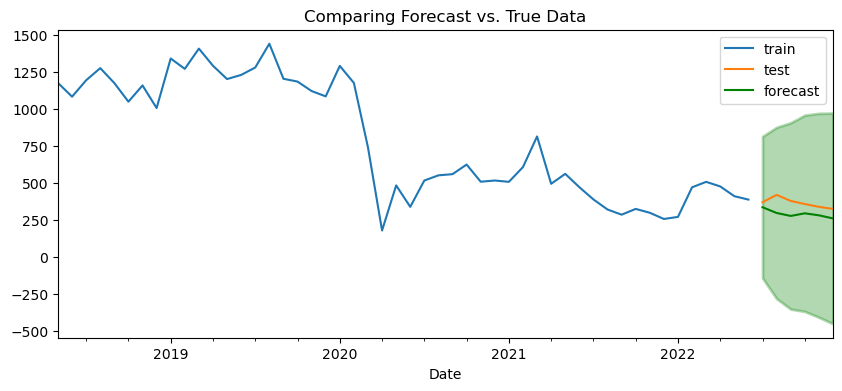

In [27]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 50)

In [28]:
# Get time series regression metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 73.631
- MSE = 6,293.879
- RMSE = 79.334
- R^2 = -5.779
- MAPE = 19.87%


- The range for the forecast looks quite large in comparison, but the forecast line follows the real data somewhat closely.

#### auto_arima Model

In [72]:
import pmdarima as pm
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3669.016, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3583.957, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3595.909, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3667.813, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3643.189, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3577.354, Time=0.85 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3559.635, Time=1.32 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3559.679, Time=0.54 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3559.353, Time=1.33 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3589.825, Time=0.55 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3602.922, Time=0.18 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3566.676, Time=1.21 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [73]:
# Try auto_arima orders
auto_sarima = tsa.ARIMA(train, 
                   order = auto_model.order,
                   seasonal_order=auto_model.seasonal_order).fit()
# Obtain summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             ARIMA(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1764.670
Date:                            Fri, 08 Dec 2023   AIC                           3543.341
Time:                                    18:02:55   BIC                           3568.184
Sample:                                01-31-2001   HQIC                          3553.332
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2524      0.042     -5.976      0.000      -0.335      -0.170
ar.L2         -0.1862      0.053     -3.528      0.000      -0.290      -0.083
ar.L3         -0.2032      0.058     -3.488      0.000      -0.317      -0.089
ar.L4         -0.1967      0.061     -3.247      0.001      -0.315      -0.078
ar.S.L12       0.9384      0.032     29.749      0.000       0.877       1.000
ma.S.L12      -0.7208      0.081     -8.953      0.000      -0.879      -0.563
sigma2      5.296e+04   3683.359     14.379      0.000    4.57e+04    6.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

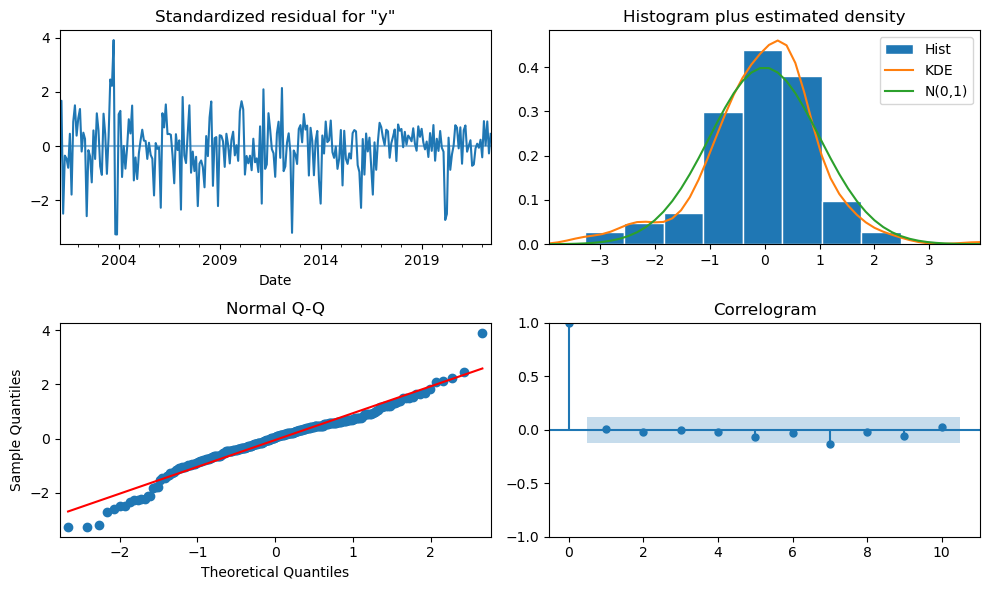

In [74]:
# Check diagnosti plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

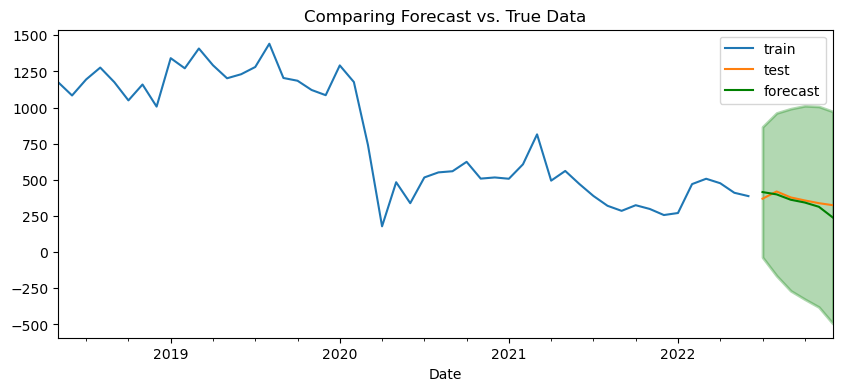

In [75]:
    # Obtain summary of forecast as dataframe
    forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
    # Plot the forecast with true values
    plot_forecast(train, test, forecast_df, n_train_lags = 50)

In [76]:
# Get time series regression metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 34.565
- MSE = 1,829.462
- RMSE = 42.772
- R^2 = -0.970
- MAPE = 9.88%


- Diagnostic plots looked good with only one single lag bordering on significant in the Correlogram, similar to the initial model.
- BIC was only marginally better in the auto_arima model.
- However, the orders chosen by auto_arima performed better is almost every other metric. MAE, MSE, RMSE, and MAPE were all cut down by roughly half or more.
- The forecast, while it still has a wide range, sticks to the true value lines more closely.
- With this in mind the seasonal auto_arima is chosen as **the final model order, ARIMA(4,1,0)(1,0,1)[12]**

#### Forecast with Final Model Choice

- As mentioned above the final model order is ARIMA(4,1,0)(1,0,1)[12]

In [77]:
final_model = tsa.ARIMA(narc_ts, 
                         order = auto_model.order, 
                         seasonal_order=auto_model.seasonal_order
).fit()

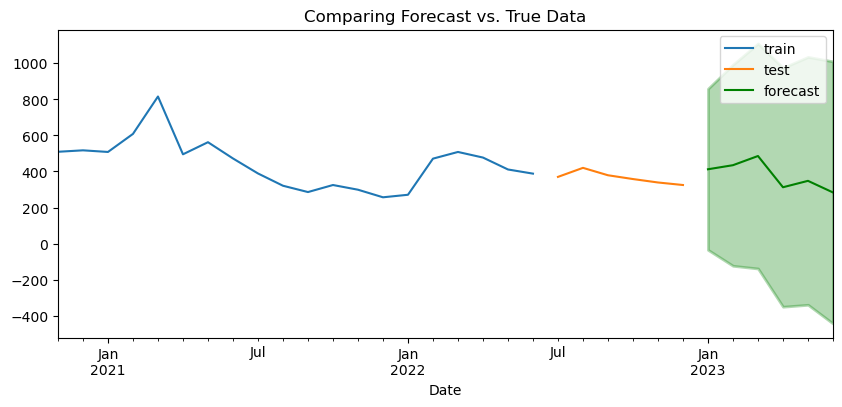

In [78]:
# Get forecast into future (fit on entire time series)
forecast_df = final_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df, n_train_lags=20);

#### Model Assessment and Recommendations

In [79]:
# Define starting and final values
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
# Change in x
delta = final_value - starting_value
print(f'The change in Number of Narcotics-related crimes over the forecast is {delta: .0f}.')
perc_change = (delta/starting_value) *100
print (f'The percentage change in crimes is {perc_change :.2f}%.')

The change in Number of Narcotics-related crimes over the forecast is -128.
The percentage change in crimes is -31.14%.


- The overall trend for narcotics crimes has been decreasing over the years, from highs around 5,000 crimes in the early 2000's, to the neighborhood of 500 crimes per year over the past couple years.
- The effects of seasonality played a modest role in determining the number of crimes, accounting for just under 10% of the total.
- The forecast shows a continued slow decline; perhaps contine working on drug-treatment programs or other policies that had been implemented over the past years which seem to be having favorable results.

### Assault

#### Examine and prepare data for analysis

In [37]:
# Select only narcotics data for analysis
asl_ts = ts[ts['Primary Type'] == 'ASSAULT']
asl_ts

,Primary Type
Date,
2001-01-01 01:00:00,ASSAULT
2001-01-01 13:00:00,ASSAULT
2001-01-01 13:00:00,ASSAULT
2001-01-01 01:02:29,ASSAULT
2001-01-01 01:07:38,ASSAULT
...,...
2022-12-31 12:38:00,ASSAULT
2022-12-31 00:41:00,ASSAULT
2022-12-31 12:50:00,ASSAULT


In [38]:
# Resample the dataframe as monthly frequency
asl_ts = asl_ts.resample('M').size()
asl_ts

Date
2001-01-31    2123
2001-02-28    2029
2001-03-31    2824
2001-04-30    2746
2001-05-31    2903
              ... 
2022-08-31    1984
2022-09-30    1891
2022-10-31    1839
2022-11-30    1659
2022-12-31    1569
Freq: M, Length: 264, dtype: int64

**Check for nulls**

In [39]:
# Check nulls
asl_ts.isna().sum()

0

**Seasonality**

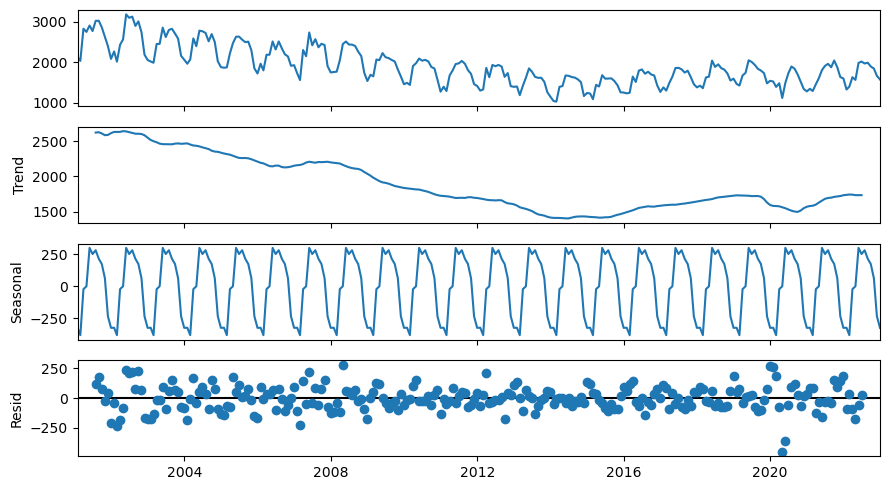

In [40]:
# Use seasonal decompose to check for seasonality
decomp = tsa.seasonal_decompose(asl_ts)
fig = decomp.plot()
fig.set_size_inches(9,5)
fig.tight_layout()

In [41]:
# Assess absolute and relative size of seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {round(seasonal_delta,2)} which is ~{seasonal_delta/(asl_ts.max()-asl_ts.min()) * 100 :.2f}% of the variation in time series.") 

The seasonal component is 684.89 which is ~31.75% of the variation in time series.


**Stationarity**

In [42]:
# Check ndiffs and nsdiffs
d = ndiffs(asl_ts)
print(f'd = {d}')
D = nsdiffs(asl_ts, m=12)
print(f'D = {D}')

d = 1
D = 0


In [43]:
# Check stationarity
get_adfuller_results(asl_ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.836624,15,248,0.362437,0.05,False


In [44]:
# Apply differencing, check again
asl_diff = asl_ts.diff().dropna()
get_adfuller_results(asl_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.936162,14,248,0.001784,0.05,True


**ACF/PACF Plots**

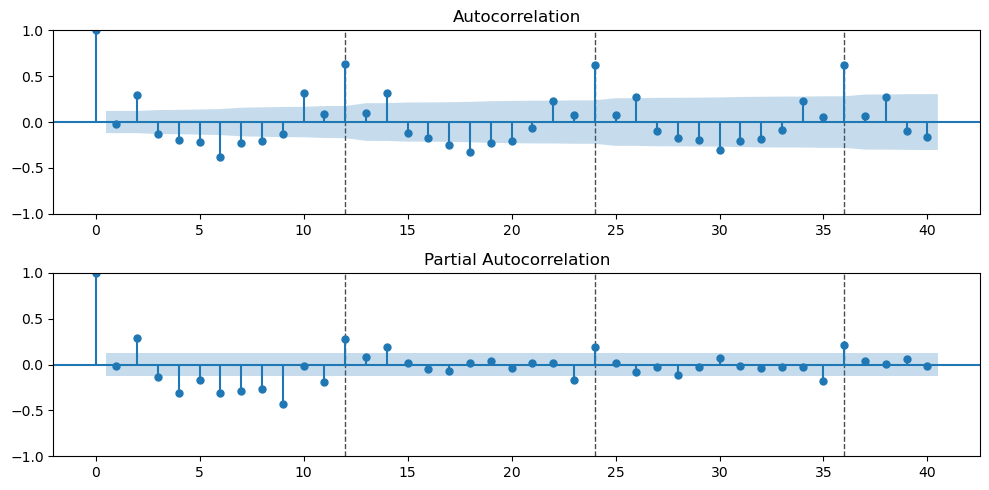

In [45]:
# Obtain autocorrelation plots
plot_acf_pacf(asl_diff, annotate_seas=True, m=12);

- For nonseasonal both models have significant lags at different points without a clear drop at any point. With neither having a strong drop, try ARMA 1, 1.
- Much like the nonseasonal lags, the seasonal don't appear to have a dramatic drop at any point either. With this in mind again try ARIMA 1, 1 for the seasonal model.

**TTS**

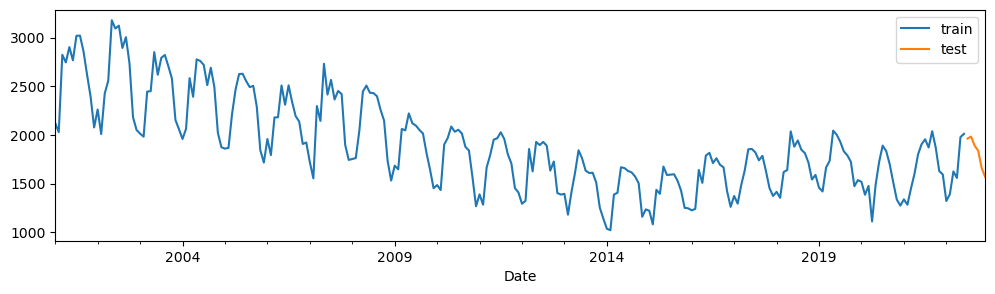

In [46]:
train, test = train_test_split(asl_ts, test_size=6)

## Visualize train-test-split
ax = train.plot(label="train")
test.plot(label="test")
ax.legend();

#### Initial SARIMA Model

In [47]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components (if seasonal model)
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
# Examine model summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1611.968
Date:                          Fri, 08 Dec 2023   AIC                           3233.936
Time:                                  17:34:09   BIC                           3251.681
Sample:                              01-31-2001   HQIC                          3241.072
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.044     21.712      0.000       0.877       1.051
ma.L1         -0.9993      0.068    -14.621      0.000      -1.133      -0.865
ar.S.L12       0.9933      0.005    198.298      0.000       0.984       1.003
ma.S.L12      -0.8212      0.065    -12.700      0.000      -0.948      -0.694
sigma2      1.645e+04    565.131     29.100      0.000    1.53e+04    1.76e+04
===================================================================================
Ljung-Box (L1) (Q):                  21.43   Jarque-Bera (JB):                20.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

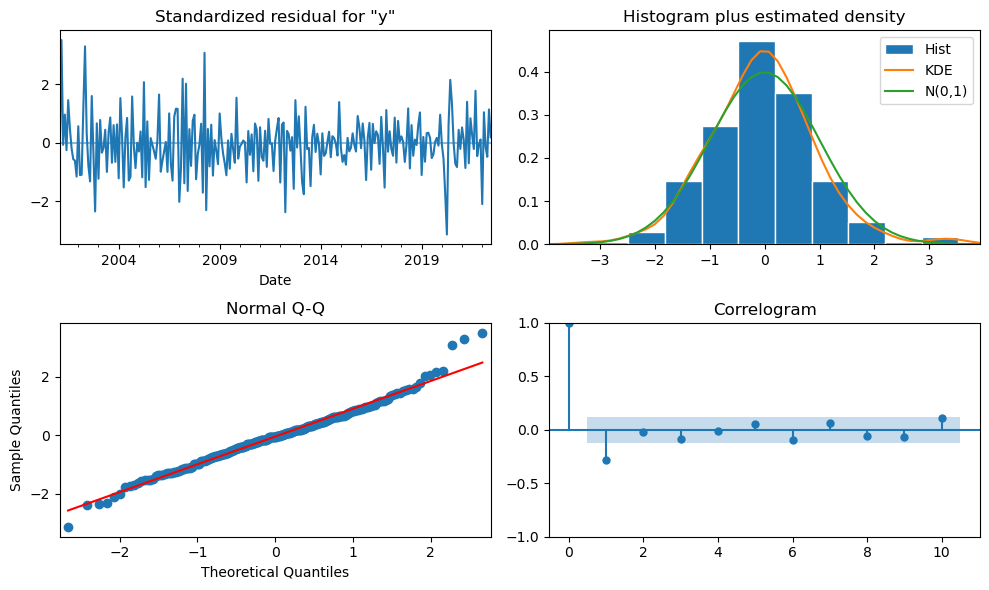

In [49]:
# Check diagnosti plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- Lag 1 indicates there may be more the model could capture; perharps a better version will be found with auto_arima

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

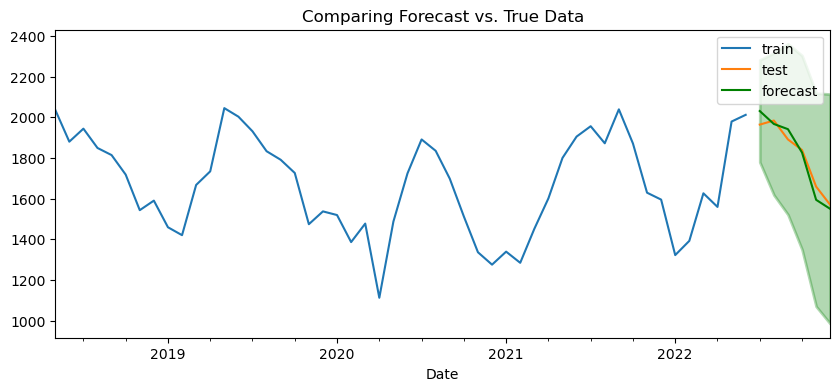

In [50]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 50)

In [51]:
# Get time series regression metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 38.600
- MSE = 2,012.266
- RMSE = 44.858
- R^2 = 0.915
- MAPE = 2.13%


#### auto_arima Model

In [52]:
import pmdarima as pm
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.20 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.17 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [53]:
# Try auto_arima orders
auto_sarima = tsa.ARIMA(train, 
                   order = auto_model.order,
                   seasonal_order=auto_model.seasonal_order).fit()
# Obtain summary
auto_sarima.summary()

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  258
Model:             ARIMA(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1592.692
Date:                               Fri, 08 Dec 2023   AIC                           3203.383
Time:                                       17:34:59   BIC                           3235.325
Sample:                                   01-31-2001   HQIC                          3216.229
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4170      0.060     -6.977      0.000      -0.534      -0.300
ar.L2         -0.2500      0.065     -3.826      0.000      -0.378      -0.122
ar.L3         -0.2374      0.061     -3.922      0.000      -0.356      -0.119
ar.L4         -0.1568      0.063     -2.492      0.013      -0.280      -0.033
ar.S.L12       1.9974      0.011    183.527      0.000       1.976       2.019
ar.S.L24      -0.9986      0.011    -94.440      0.000      -1.019      -0.978
ma.S.L12      -1.9797      0.082    -24.079      0.000      -2.141      -1.819
ma.S.L24       0.9850      0.088     11.147      0.000       0.812       1.158
sigma2      1.066e+04   1.61e-05   6.64e+08      0.000    1.07e+04    1.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.48
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+24. Standard errors may be unstable.
"""

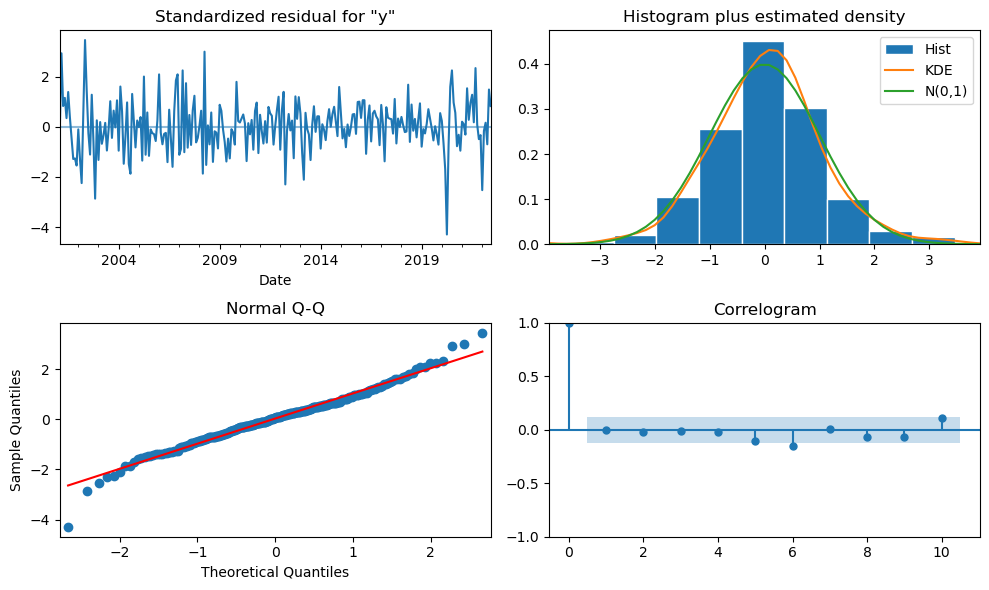

In [54]:
# Check diagnosti plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

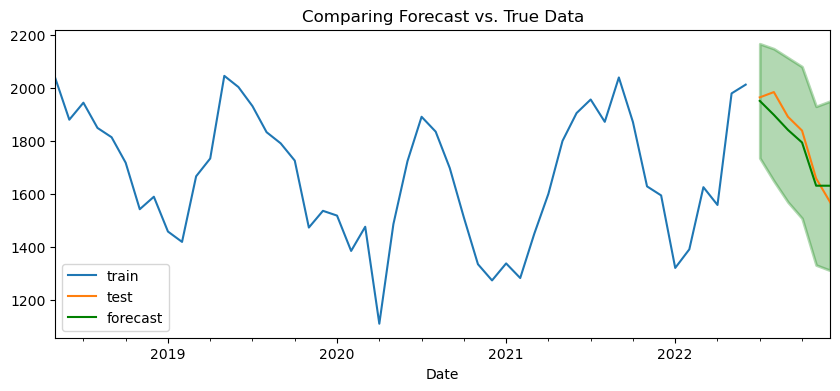

In [55]:
# Obtain summary of forecast as dataframe
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 50)

In [56]:
# Get time series regression metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 47.168
- MSE = 2,771.973
- RMSE = 52.650
- R^2 = 0.883
- MAPE = 2.61%


- Diagnostic plots were similar with one lag bordering on significant in the Correlogram.
- BIC was only marginally better in the auto_arima model.
- The orders initially chosen performed better in most metrics. MAE, MSE, RMSE, and MAPE were all reduced and R^2 improved.
- Based on this the original model is chosen as **the final model order, ARIMA(1,1,1)(1,0,1)[12]**

#### Forecast with Final Model Choice

In [57]:
p = 1
d = 1
q = 1

P = 1
D = 0
Q = 1
m = 12

final_model = tsa.ARIMA(asl_ts, order = (p, d, q), seasonal_order = (P, D, Q, m)).fit()

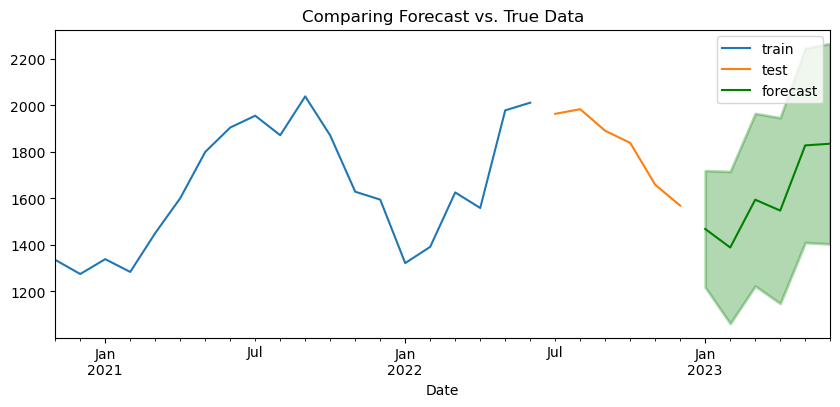

In [58]:
# Get forecast into future (fit on entire time series)
forecast_df = final_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df, n_train_lags=20);

#### Model Assessment and Recommendations

In [59]:
# Define starting and final values
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
# Change in x
delta = final_value - starting_value
print(f'The change in number of reported assaults over the forecast is {delta: .0f}.')
perc_change = (delta/starting_value) *100
print (f'The percentage change in assaults is {perc_change :.2f}%.')

The change in number of reported assaults over the forecast is  367.
The percentage change in assaults is 24.97%.


- Assaults saw a decrease from early 2000's to until about 2015, dropping from an average of around 2,500 per year to 1,500. After this time, however, the trend started slowly increasing.
- The seasonality of assaults is much more pronounced than that of narcotics related crime, accounting for nearly a third of the variation.
- Considering the forecast if for the period of time when assaults are on the upswing, I would advise stakeholders to be prepared for an increased amount of violent crime over the coming months.

## Final Evaluation

**Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?**
- Assault had the highest amount of crimes, with 1,835 predicted at the end of the forecast.
- Narcotics-related crimes meanwhile only had 283 crimes predicted.

**Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?**
- Assault is predicted to have a higher net change, with an increase of 367 over the time period.
- Narcotics crimes are actually forecasted to decrease by 128.

**Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?**
- Assults are expected to increase by 24.97%, which makes it the largest change in the positive direction.
- Narcotics-related crimes are forecasted to continue to decrease, but the decrease actually has a larger absolute value than the increase for assaults, coming in at an expected -31.14% change.